# 네이버 영화, 쇼핑 리뷰 분석

### 1. 필요한 모듈 불러오기 및 데이터 로딩

- Mecab 설치

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220111.sh

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings

seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)
warnings.filterwarnings('ignore')

In [3]:
movie_train = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', sep = '\t')
movie_test = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', sep = '\t')
movie_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [4]:
url = 'https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt'
shp = pd.read_table(url, names = ['ratings', 'reviews'])
shp

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


### 2. 데이터 전처리

- movie_train, movie_test, shp를 하나의 데이터프레임으로 합치기

In [5]:
movie_train.drop(columns = ['id'], inplace = True)
movie_test.drop(columns = ['id'], inplace = True)
movie_train

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...
149995,인간이 문제지.. 소는 뭔죄인가..,0
149996,평점이 너무 낮아서...,1
149997,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [6]:
movie_train.rename(columns = {'document' : 'reviews'}, inplace = True)
movie_test.rename(columns = {'document' : 'reviews'}, inplace = True)
movie_test.head()

,reviews,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [7]:
shp['label'] = shp.apply(lambda x : 1 if x.ratings > 3 else 0, axis = 1)
shp

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
...,...,...,...
199995,2,장마라그런가!!! 달지않아요,0
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,1
199998,5,넘이쁘고 쎄련되보이네요~,1


In [8]:
shp = shp.drop(columns = 'ratings')
shp

,reviews,label
0,배공빠르고 굿,1
1,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
...,...,...
199995,장마라그런가!!! 달지않아요,0
199996,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1
199997,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,1
199998,넘이쁘고 쎄련되보이네요~,1


In [9]:
df = pd.concat([movie_train, movie_test, shp])
df = df.reset_index(drop=True)
df

,reviews,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...
399995,장마라그런가!!! 달지않아요,0
399996,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1
399997,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,1
399998,넘이쁘고 쎄련되보이네요~,1


- Null data 확인 및 제거

In [10]:
df.isna().sum()

reviews    8
label      0
dtype: int64

In [11]:
df.dropna(how = 'any', inplace = True)
df.isna().sum()

reviews    0
label      0
dtype: int64

- 중복데이터 확인 및 제거

In [12]:
df.shape, df['reviews'].nunique()

((399992, 2), 394422)

In [13]:
df.drop_duplicates(subset = ['reviews'], inplace = True)
df.shape

(394422, 2)

- 한글 이외의 데이터는 제거

In [14]:
df['reviews'] = df['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
df['reviews'].replace('', np.nan, inplace=True)
df.isna().sum()

reviews    491
label        0
dtype: int64

In [15]:
df.dropna(how = 'any', inplace = True)
df.shape

(393931, 2)

In [16]:
df

,reviews,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...
399995,장마라그런가 달지않아요,0
399996,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1
399997,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,1
399998,넘이쁘고 쎄련되보이네요,1


### 3. 훈련/테스트 데이터셋 분리

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.reviews, df.label, stratify = df.label, random_state = 2022
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((295448,), (98483,), (295448,), (98483,))

In [18]:
np.unique(y_train, return_counts = True)

(array([0, 1]), array([147803, 147645]))

### 4. 토큰화

- 형태소 분석

In [19]:
from konlpy.tag import Mecab

In [20]:
mecab = Mecab()
print(mecab.morphs('와 진심 명작이다 이런 영화 다시 없어요 여러분'))

['와', '진심', '명작', '이', '다', '이런', '영화', '다시', '없', '어요', '여러분']


In [21]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [22]:
tok_list = []
for review in X_train:
    morphs = mecab.morphs(review)
    morphs = [item for item in morphs if item not in stopwords]
    tok_list.append(morphs)

X_train = tok_list

In [23]:
print(X_train[0])

['빵빵', '네요', '만족']


In [24]:
tok_list = []
for review in X_test:
    morphs = mecab.morphs(review)
    morphs = [item for item in morphs if item not in stopwords]
    tok_list.append(morphs)

X_test = tok_list

In [25]:
print(X_test[0])

['보', '난', '후', '아무', '생각', '안', '드', '생각', '없', '영화']


- 단어와 길이 분포 확인하기

In [26]:
y_train[0]

0

In [27]:
positive_words = []
for i in range(len(y_train)):
    if y_train.iloc[i] == 1:    # DataFrame의 경우 key error가 났다는 것은 index가 빠졌다는 얘기, numpy array를 쓰거나 iloc를 써야한다
        positive_words += X_train[i]

In [28]:
from collections import Counter

positive_words_count = Counter(positive_words)
print(positive_words[:20])

['빵빵', '네요', '만족', '먹', '나', '면', '재', '구매', '할게요', '보', '나', '서', '빠져', '나오', '질', '못해', '계속', '찾아보', '나', '슬픈']


In [29]:
print(positive_words_count.most_common(20))

[('좋', 49203), ('영화', 29640), ('네요', 25896), ('잘', 23280), ('어요', 23254), ('있', 22881), ('아요', 22262), ('는데', 17594), ('습니다', 17566), ('보', 17365), ('구매', 16272), ('너무', 14336), ('했', 13626), ('같', 12153), ('배송', 12125), ('었', 11488), ('합니다', 11092), ('재', 10743), ('아', 10557), ('어', 10520)]


In [30]:
negative_words = []
for i in range(len(y_train)):
    if y_train.iloc[i] == 0:    # DataFrame의 경우 key error가 났다는 것은 index가 빠졌다는 얘기, numpy array를 쓰거나 iloc를 써야한다
        negative_words += X_train[i]

In [31]:
negative_words_count = Counter(negative_words)
print(negative_words[:20])

['시간', '아깝', '어린', '여주', '연기', '인상', '적', '었', '나중', '기대', '되', '어서', '좋', '았', '남주', '여주', '외모', '꽤', '반반', '해서']


In [32]:
print(negative_words_count.most_common(20))

[('네요', 34559), ('영화', 28151), ('안', 26378), ('는데', 25867), ('없', 19804), ('있', 19221), ('너무', 18321), ('보', 17460), ('했', 15967), ('어요', 15841), ('나', 14850), ('만', 13984), ('거', 13720), ('좋', 13629), ('어', 13439), ('같', 13349), ('되', 12211), ('않', 11894), ('로', 11776), ('기', 11296)]


In [33]:
df['tokenized'] = df['reviews'].apply(mecab.morphs)

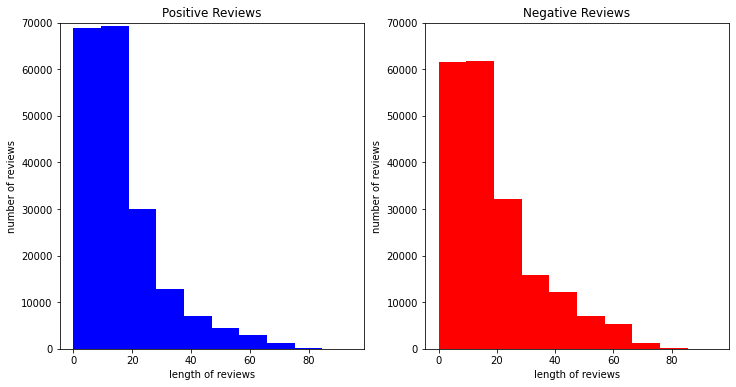

In [34]:
plt.figure(figsize = (12, 6))

plt.subplot(121)
pos_len = df.loc[df['label'] == 1, 'tokenized'].apply(lambda x : len(x))
plt.hist(pos_len, color = 'blue')
plt.title('Positive Reviews')
plt.xlabel('length of reviews')
plt.ylabel('number of reviews')
plt.ylim(0, 70000)

plt.subplot(122)
neg_len = df.loc[df['label'] == 0, 'tokenized'].apply(lambda x : len(x))
plt.hist(neg_len, color = 'red')
plt.title('Negative Reviews')
plt.xlabel('length of reviews')
plt.ylabel('number of reviews')
plt.ylim(0, 70000)

plt.show()

In [35]:
print('긍정 리뷰의 평균 길이 :', np.mean(pos_len))
print('부정 리뷰의 평균 길이 :', np.mean(neg_len))

긍정 리뷰의 평균 길이 : 16.567418469978666
부정 리뷰의 평균 길이 : 19.112700498804998


#### 부정 리뷰의 경우 긍정리뷰보다 길이가 더 긴 것을 확인할 수 있다

- 인코딩

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer

tok = Tokenizer()
tok.fit_on_texts(X_train)

In [37]:
threshold = 3
total_cnt = len(tok.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

In [38]:
for key, value in tok.word_counts.items():
    total_freq += value
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

In [39]:
print(f'단어 집합(vocabulary)의 크기 : {total_cnt}')
print(f'등장빈도가 {threshold - 1}번 이하인 희귀 단어의 수 : {rare_cnt}')
print(f'단어 집합에서 희귀 단어의 비율 : {rare_cnt / total_cnt * 100}')
print(f'전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : {rare_freq / total_freq * 100}')

단어 집합(vocabulary)의 크기 : 70891
등장빈도가 2번 이하인 희귀 단어의 수 : 39544
단어 집합에서 희귀 단어의 비율 : 55.78141089842153
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 1.1855331044831343


- 등장 빈도가 2회 이하인 단어는 제외하고 토큰화

In [40]:
vocab_size = total_cnt - rare_cnt + 2
vocab_size

31349

In [41]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

- 패딩

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 13.831591346023666


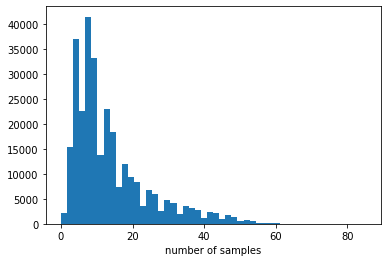

In [42]:
print('리뷰의 최대 길이 :', max(len(review) for review in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train)) / len(X_train))

plt.hist([len(review) for review in X_train], bins = 50)
plt.xlabel('length of samples')
plt.xlabel('number of samples')
plt.show()

In [43]:
# 리뷰 길이를 60으로 padding
max_len = 60

In [44]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [45]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, 1911,    3,   75], dtype=int32)

### 5. 모델 설정/정의/평가

In [64]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Conv1D, LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

a) SimpleRNN

In [51]:
del model

In [52]:
model = Sequential([
                    Embedding(vocab_size, 100, input_length = max_len),
                    SimpleRNN(32),
                    Dense(16, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           3134900   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,139,701
Trainable params: 3,139,701
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])

model_path = 'best-review-srnn.h5'
mc = ModelCheckpoint(model_path, save_best_only = True, verbose = 1)
es = EarlyStopping(patience = 5)

In [ ]:
hist = model.fit(
    X_train, y_train, epochs = 50, batch_size = 256,
    validation_split = 0.2, callbacks = [mc, es]
)

In [55]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

3078/3078 [==============================] - 28s 9ms/step - loss: 0.3266 - accuracy: 0.8639


[0.32660409808158875, 0.8639156222343445]

b) GRU

In [56]:
model2 = Sequential([
                    Embedding(vocab_size, 100, input_length = max_len),
                    GRU(64),
                    Dense(16, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 100)           3134900   
                                                                 
 gru (GRU)                   (None, 64)                31872     
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,167,829
Trainable params: 3,167,829
Non-trainable params: 0
_________________________________________________________________


In [57]:
model2.compile('adam', 'binary_crossentropy', ['accuracy'])

model_path = 'best-review-gru.h5'
mc = ModelCheckpoint(model_path, save_best_only = True, verbose = 1)
es = EarlyStopping(patience = 5)

In [ ]:
hist2 = model2.fit(
    X_train, y_train, epochs = 50, batch_size = 256,
    validation_split = 0.2, callbacks = [mc, es]
)

In [59]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

3078/3078 [==============================] - 22s 7ms/step - loss: 0.2847 - accuracy: 0.8824


[0.28474438190460205, 0.8824365735054016]

c) LSTM

In [60]:
model3 = Sequential([
                    Embedding(vocab_size, 100, input_length = max_len),
                    LSTM(64),
                    Dense(16, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 60, 100)           3134900   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,178,197
Trainable params: 3,178,197
Non-trainable params: 0
_________________________________________________________________


In [61]:
model3.compile('adam', 'binary_crossentropy', ['accuracy'])

model_path = 'best-review-lstm.h5'
mc = ModelCheckpoint(model_path, save_best_only = True, verbose = 1)
es = EarlyStopping(patience = 5)

In [ ]:
hist3 = model3.fit(
    X_train, y_train, epochs = 50, batch_size = 256,
    validation_split = 0.2, callbacks = [mc, es]
)

In [63]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

3078/3078 [==============================] - 22s 7ms/step - loss: 0.2873 - accuracy: 0.8821


[0.2873002588748932, 0.8820506930351257]

d) Conv1D

In [79]:
model4 = Sequential([
                    Embedding(vocab_size, 100, input_length = max_len),
                    Dropout(0.5),
                    Conv1D(64, 7, activation = 'relu'),
                    MaxPooling1D(5),
                    Conv1D(32, 5, activation = 'relu'),
                    MaxPooling1D(3),
                    GlobalMaxPooling1D(),
                    Dense(16, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])
model4.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 60, 100)           3134900   
                                                                 
 dropout_14 (Dropout)        (None, 60, 100)           0         
                                                                 
 conv1d_28 (Conv1D)          (None, 54, 64)            44864     
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 10, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 6, 32)             10272     
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 2, 32)            0         
 g1D)                                                

In [80]:
model4.compile('adam', 'binary_crossentropy', ['accuracy'])

model_path = 'best-review-lstm.h5'
mc = ModelCheckpoint(model_path, save_best_only = True, verbose = 1)
es = EarlyStopping(patience = 5)

In [ ]:
hist4 = model4.fit(
    X_train, y_train, epochs = 50, batch_size = 256,
    validation_split = 0.2, callbacks = [mc, es]
)

In [82]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

3078/3078 [==============================] - 11s 4ms/step - loss: 0.4382 - accuracy: 0.7726


[0.4382040798664093, 0.7726003527641296]

### 결론 : 여러 모델 중 GRU, LSTM의 리뷰 분석 성능이 가장 뛰어난 것으로 보이며, Conv1D의 경우 예측 성능이 크게 뛰어나진 않은 것으로 보인다.